# Building a semantic network from a data set of CNN articles

### Identifying 'concepts' with Entities from Spacy

In [80]:
#loading some imports
import warnings
import pandas as pd
import numpy as np
import spacy
import seaborn as sns


import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

nlp = spacy.load('en_core_web_sm')

warnings.filterwarnings("ignore")


# Loading the dataset as a DataFrame

### Originally from: https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning

In [81]:
df_cnn = pd.read_csv('Data/CNN_Articles/CNN_Articels_clean.csv')
#remove nans
df_cnn.dropna(inplace=True)

# Taking a look at the dataframe and some statistics

In [82]:
df_cnn.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


### Article categories

<AxesSubplot:xlabel='Category', ylabel='count'>

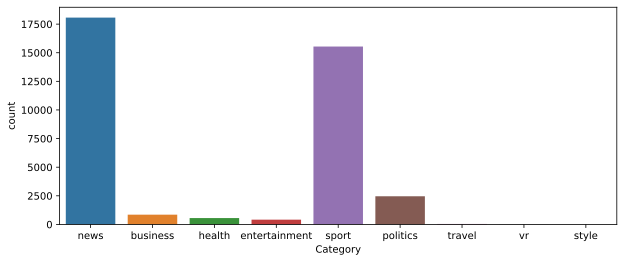

In [83]:
plt.figure(figsize=(10,4))
sns.countplot(df_cnn['Category'])

In [153]:
df_cnn[df_cnn['Category'] == 'news']['Section'].unique()

array(['world', 'asia', 'us', 'africa', 'opinions', 'europe', 'china',
       'living', 'americas', 'middleeast', 'india', 'weather',
       'intl_world', 'uk', 'opinion', 'worldsport', 'australia',
       'justice', 'app-news-section', 'cnn10', 'app-politics-section',
       'app-tech-section'], dtype=object)

## Comparing Full text, description and headline lenghts

In [84]:
art_lenghts = [df_cnn['Article text'].apply(lambda text: len(text.split(' '))) ,df_cnn['Headline'].apply(lambda text: len(text.split(' '))) ,df_cnn['Description'].apply(lambda text: len(text.split(' ')))]


Text(0, 0.5, 'Count')

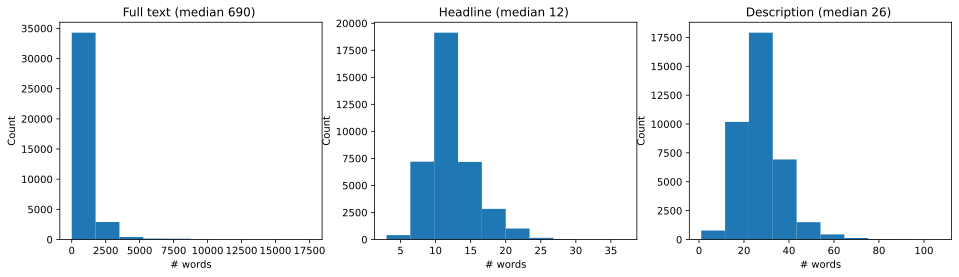

In [85]:
fig, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].hist(art_lenghts[0])
ax[0].set_title(f'Full text (median {np.median(art_lenghts[0]):.0f}) ')
ax[0].set_xlabel('# words')
ax[0].set_ylabel('Count')

ax[1].hist(art_lenghts[1])
ax[1].set_title(f'Headline (median {np.median(art_lenghts[1]):.0f}) ')
ax[1].set_xlabel('# words')
ax[1].set_ylabel('Count')

ax[2].hist(art_lenghts[2])
ax[2].set_title(f'Description (median {np.median(art_lenghts[2]):.0f}) ')
ax[2].set_xlabel('# words')
ax[2].set_ylabel('Count')


## For simplicity we are going to use the Description of each article to extract named entities

## We are going to create a new dataset (subset) with ``n_articles`` of articles for each category (news to politics)

In [137]:
#categories to use
use_cat = df_cnn['Category'].unique()[1:6]
print(use_cat)

['business' 'health' 'entertainment' 'sport' 'politics']


In [138]:
new_df = pd.DataFrame(columns=df_cnn.columns)
n_articles = 400
for cat in use_cat:
    #temporal slice of dataframe
    tmp_df = df_cnn[df_cnn['Category'] == cat].copy(deep=False)
    #random choice N articles
    selec_art = np.random.choice(range(tmp_df.shape[0]), n_articles)
    #appending the new dataframe ignoring the index so the new dataframe will have new indexes
    new_df = pd.concat([new_df, tmp_df.iloc[selec_art]], ignore_index=True)


## Inspecting entities in some examples

In [173]:
des = nlp(new_df['Article text'][0])

In [174]:
from spacy import displacy 

displacy.render(des, style='ent')


## We are going to ignore the cardinals and all dates and numbers...
## Considering only the type of entities in the next list

In [147]:
ent_type = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT','WORK_OF_ART', 'LAW', 'LANGUAGE']

# Storing all the entities from the new dataframe we made

In [148]:
art_ents = []
arts_used_ix = []
catego = []
for ix, text in enumerate(new_df['Description']):
    des = nlp(text)
    if len(des.ents) > 1: #storing only those who have more than 1 entities
        arts_used_ix.append(ix)
        in_ents = []
        catego.append(new_df['Category'][ix])
        for ent in des.ents:
            if ent.label_ in ent_type:
                in_ents.append(ent.text)
        
        art_ents.append(np.unique(np.array(in_ents)))


## Text length and vocabulary

In [154]:
unique_ents = [element for nestedlist in art_ents for element in nestedlist]
all_ent_len = len(unique_ents)
unique_ents = np.unique(np.array(unique_ents))
vocab_len = len(unique_ents)


In [155]:
print(f'There are {all_ent_len} named entities with {vocab_len} unique ones')


There are 4277 named entities with 1857 unique ones


# Storing entities as dictionary for tagging (map to integers)

In [156]:
word2tag = {}
tag2word = {}
for i, ent in enumerate(unique_ents):
    word2tag[ent] = i
    tag2word[i] = ent
#now for categories
cat2tag = {}
tag2cat = {}
for i, cat in enumerate(use_cat):
    cat2tag[cat] = i
    tag2cat[i] = cat

In [157]:
tag2cat

{0: 'business', 1: 'health', 2: 'entertainment', 3: 'sport', 4: 'politics'}

# We are going to use graph_tool to build and visualize a network

In [158]:
import graph_tool.all as gt 

## Initializing graph

In [159]:
#initializing graph
ent_graph = gt.Graph(directed=False)

#setting up properties for vertices and edges
v_name = ent_graph.new_vertex_property("string")
e_weight = ent_graph.new_edge_property("int")

#creating the first vertex
v = ent_graph.add_vertex()
v_name[v] = tag2word[0]



## Creating and naming the vertices

In [160]:
for i in range(1,len(tag2word)):
    v = ent_graph.add_vertex()
    v_name[v] = tag2word[i]


## Creating the edges

In [161]:
for ents in art_ents:
    if len(ents) > 1:
        for i in range(len(ents)):
            for j in range(i+1,len(ents)):
                #getting the labels for the edges
                v1 = word2tag[ents[i]]
                v2 = word2tag[ents[j]]
                #print(f'{ents[i]}, ---, {ents[j]}')
                #print(f'{v1} --- {v2}')
                neigs = ent_graph.get_all_neighbors(v1)
                #check if the edge already exists, if not it creates a new one
                if len(neigs) == 0 or v2 not in neigs:
                    e = ent_graph.add_edge(ent_graph.vertex(v1), ent_graph.vertex(v2))
                    e_weight = 1
                else: #if the edge exists it adds +1 to its weight
                    e = ent_graph.edge(v1,v2)
                    e_weight += 1
                #ent_graph.add_edge(ent_graph)

# Now we visualize the resulting graph

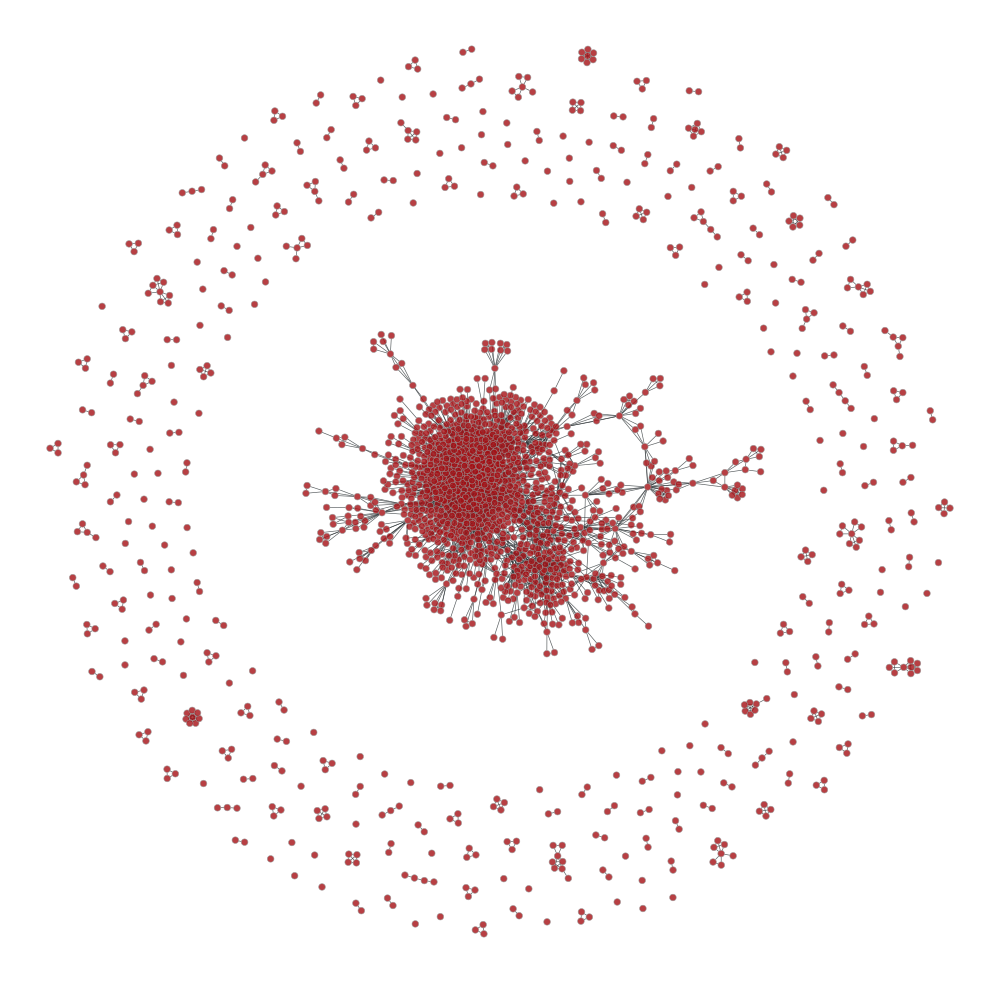

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2042a57dc0, at 0x7f2042eba080>

In [162]:
pos = gt.sfdp_layout(ent_graph)
gt.graph_draw(ent_graph, pos=pos, bg_color='white', output_size=(500, 500)
    )

# We are  going to extract the largest component in the middle to implement community detection

In [163]:
large_c = gt.extract_largest_component(ent_graph, prune=True)


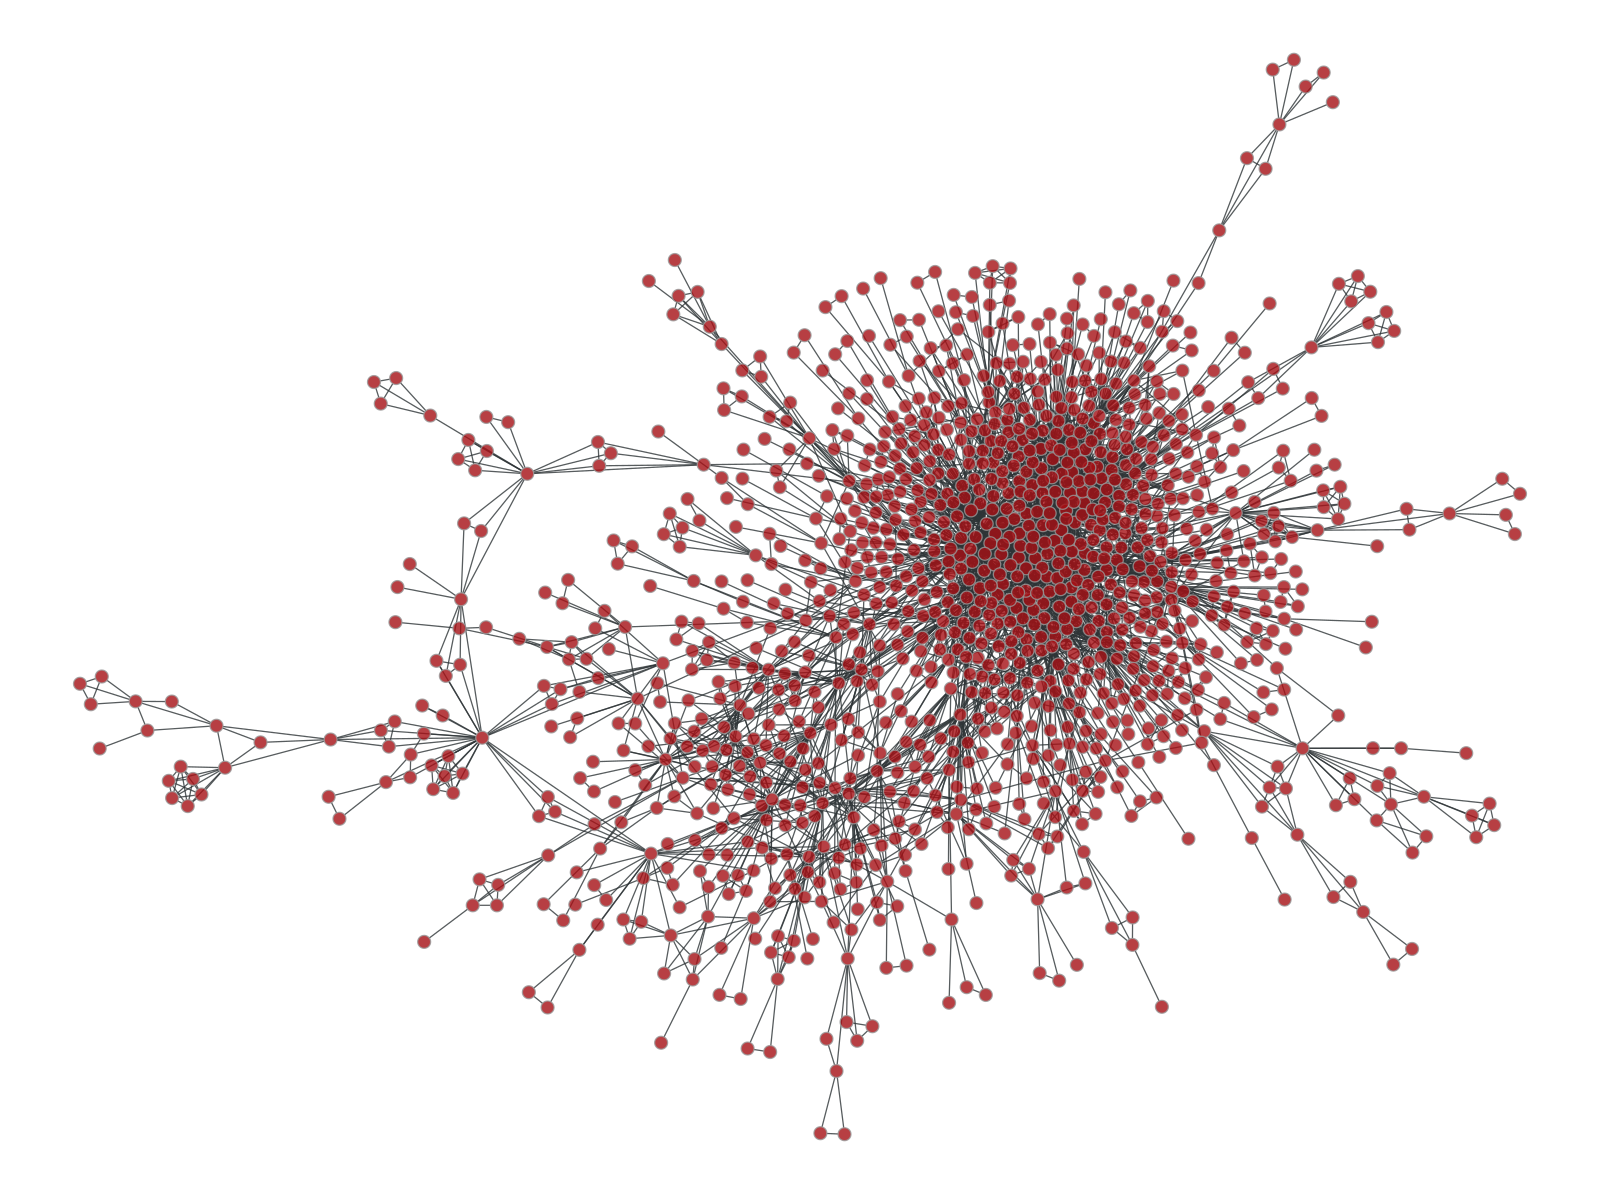

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2042a54ca0, at 0x7f2042ea53c0>

In [164]:
gt.graph_draw(large_c,bg_color='white', output_size=(800, 800))


# Applying the Stochastic Block Model for community detection

### details: https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#the-stochastic-block-model-sbm

In [165]:
state = gt.minimize_blockmodel_dl(large_c)


# Visualizing results

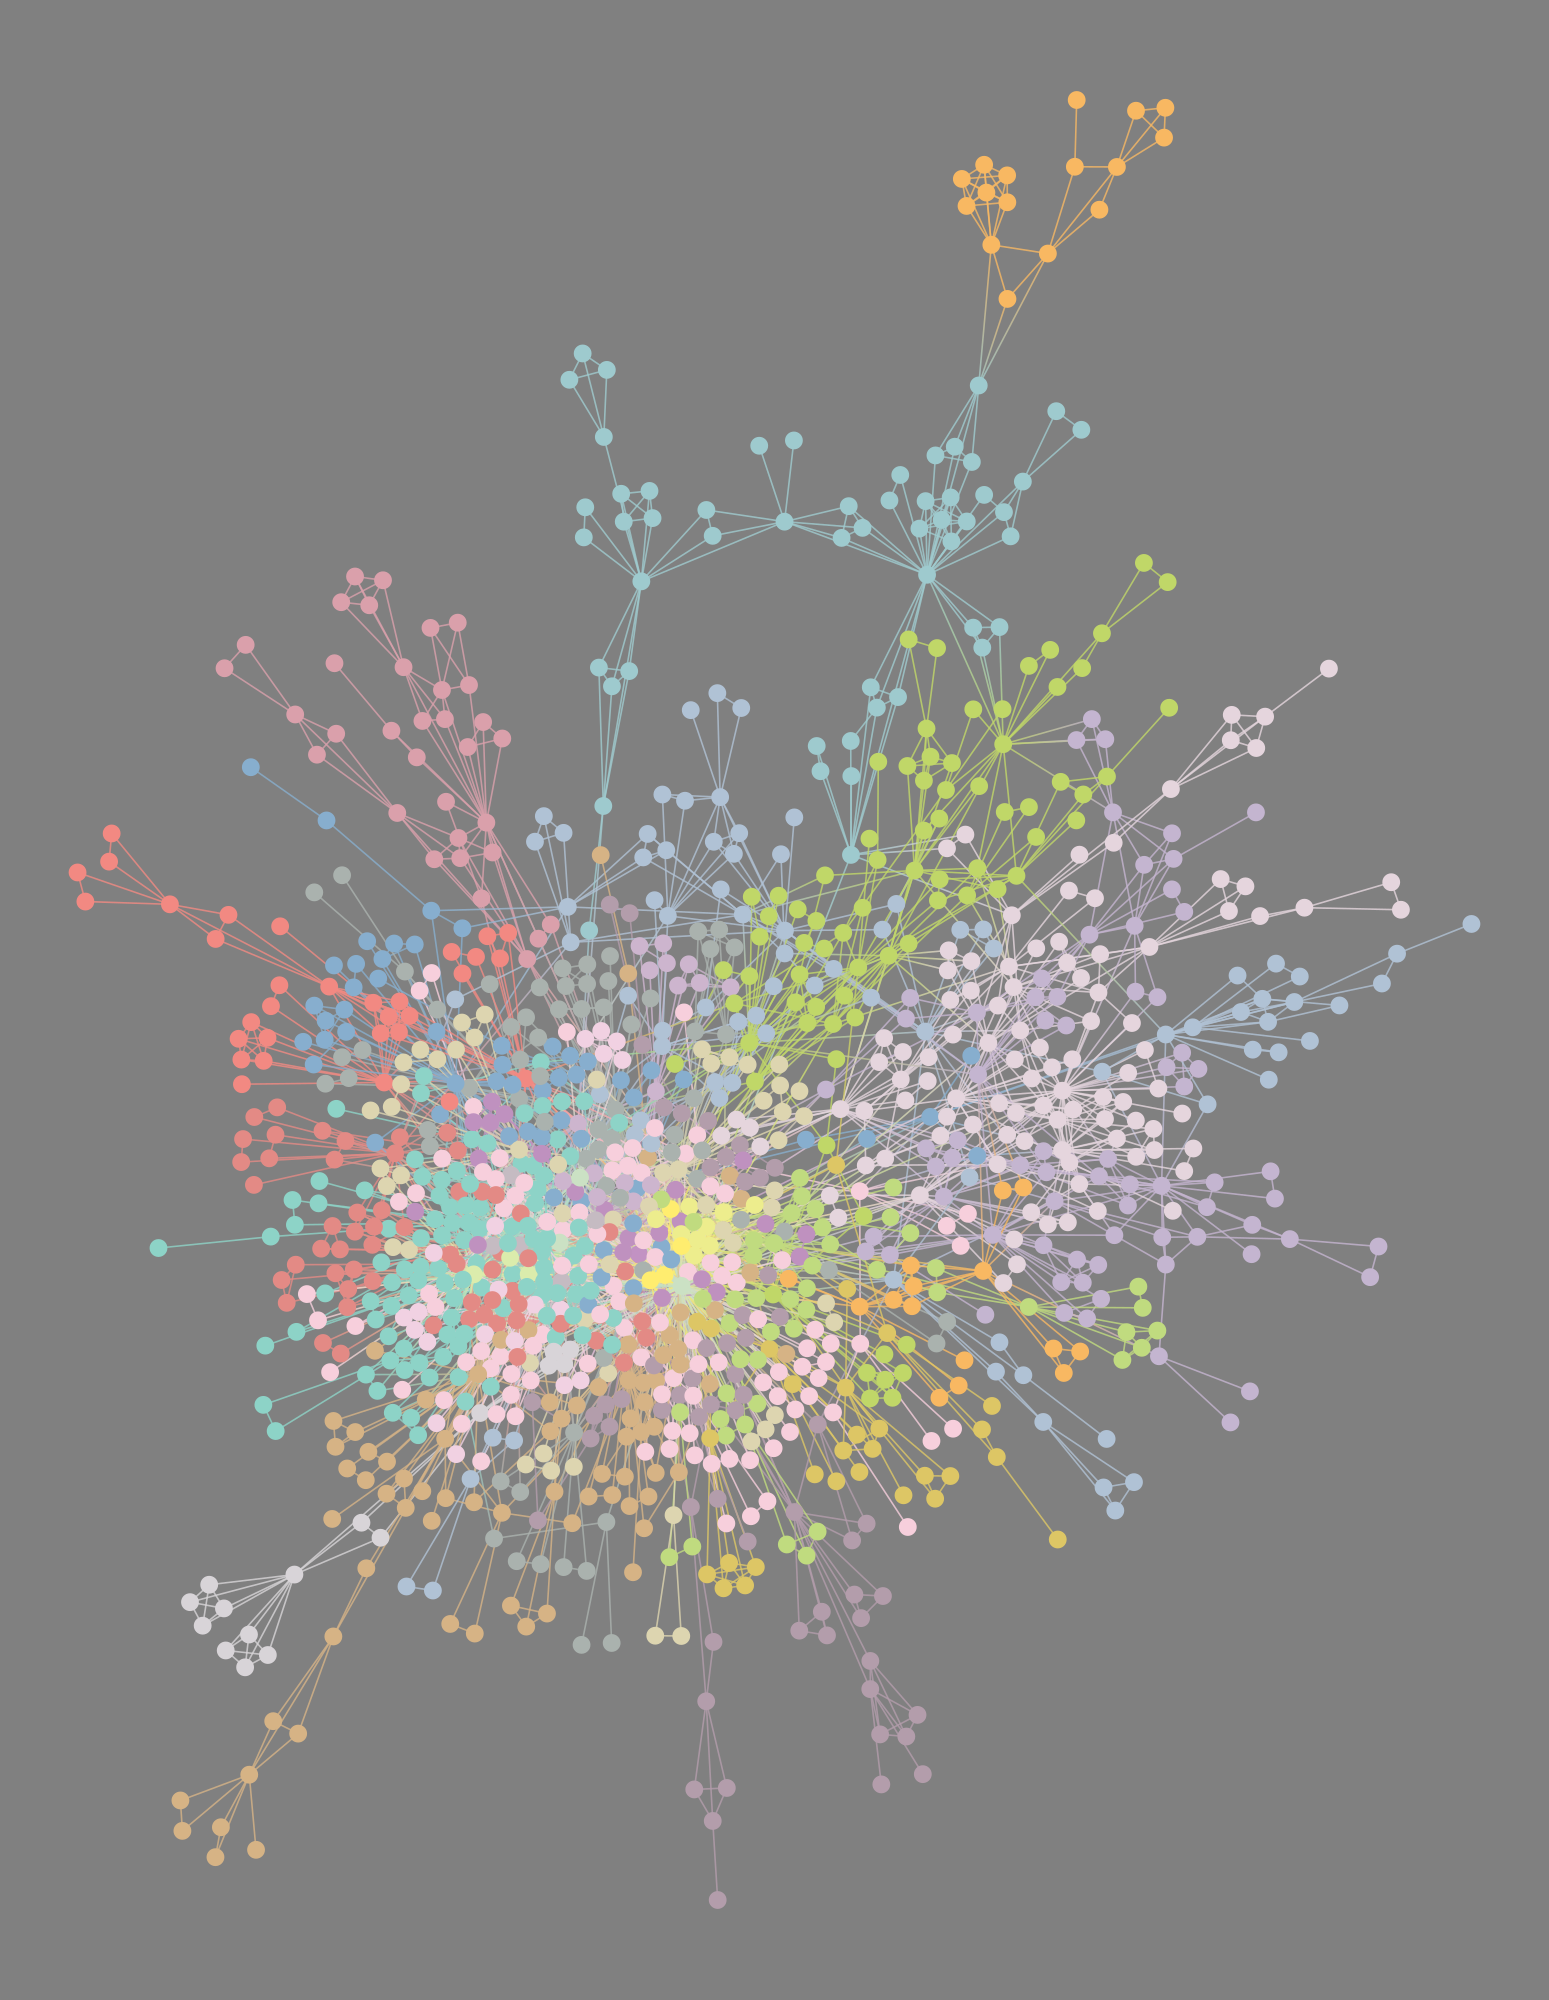

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f2042a54ca0, at 0x7f205887b010>

In [166]:
state.draw(bg_color='gray',output_size=(1000, 1000))

In [167]:
blocks = state.get_blocks()

In [168]:
groups = {}
for v in large_c.vertices():
    if blocks[v] not in groups:
        groups[blocks[v]] = [int(v)]
    else:
        groups[blocks[v]].append(int(v))


In [169]:
for key,value in groups.items():
    print(f'group {key} has {len(value)} nodes')

group 1227 has 106 nodes
group 747 has 54 nodes
group 879 has 84 nodes
group 162 has 71 nodes
group 1143 has 33 nodes
group 429 has 32 nodes
group 521 has 59 nodes
group 11 has 60 nodes
group 1116 has 57 nodes
group 353 has 67 nodes
group 142 has 78 nodes
group 132 has 31 nodes
group 1104 has 29 nodes
group 20 has 77 nodes
group 1138 has 47 nodes
group 481 has 55 nodes
group 1161 has 106 nodes
group 409 has 20 nodes
group 644 has 101 nodes
group 626 has 16 nodes
group 445 has 16 nodes
group 148 has 1 nodes
group 980 has 22 nodes
group 454 has 5 nodes
group 155 has 3 nodes
group 156 has 3 nodes
group 928 has 9 nodes
group 1229 has 4 nodes


# Inspecting the Entity names on each big group

In [175]:
[tag2word[v] for v in groups[626]]

['Anna Netrebko',
 'Azerbaijan',
 'Daimler',
 'Dak Prescott',
 'Dustin Johnson',
 'Holmes',
 'Indianapolis Colts',
 'Iran',
 'Michael Douglas',
 'Minute Maid Park',
 'Montage Palmetto Bluff',
 'Olympic Games',
 'Poland',
 'Pop Smoke',
 'Richmond',
 'Ross Perot']